1. Simulation

In [15]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


In [16]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the unde-damped harmonic oscillator problem."
    assert d< w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos

    return u



In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda')

In [18]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

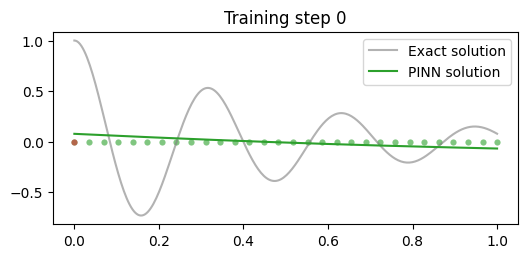

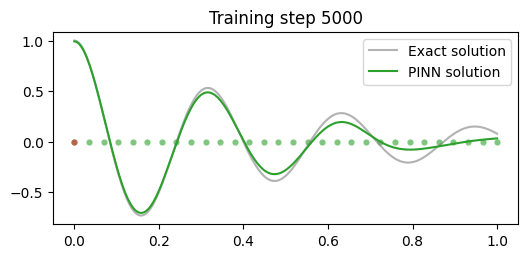

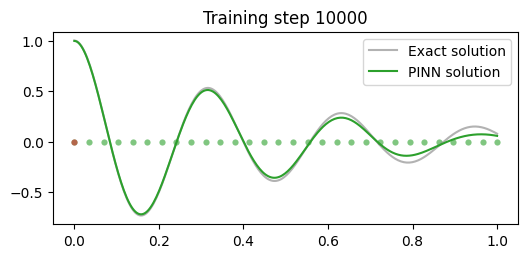

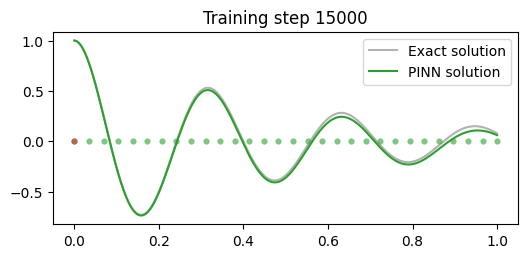

In [14]:
torch.manual_seed(123)

#define a neural network to train
pinn = FCN(1,1,32,3)

#define boundary points for boundary loss
#and colocation points for physics loss

t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True) #(1,1)
t_physics = torch.linspace(0,1,30, requires_grad = True).view(-1,1) #(30,1)


#train the pinn

d, w0 = 2, 20
mu,k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr = 1e-3)

for i in range(15001):
    optimizer.zero_grad()

    #compute each tem of the PINN loss function above
    #using the following hyperparameters

    lambda1,lambda2 = 1e-1,1e-4

    #compute boundary loss
    u =pinn(t_boundary) #(1,1)
    loss1 = (torch.squeeze(u)-1)**2
    dudt = torch.autograd.grad(u,t_boundary,torch.ones_like(u), create_graph =True)[0] #(1,1)
    loss2 = (torch.squeeze(dudt)-0)**2



    #compute physics loss
    u =pinn(t_physics) #(30,1)
    dudt = torch.autograd.grad(u,t_physics,torch.ones_like(u), create_graph =True)[0] #(30,1)
    d2udt2 = torch.autograd.grad(dudt,t_physics,torch.ones_like(u), create_graph =True)[0] #(30,1)
    loss3 = torch.mean((d2udt2+mu*dudt+k*u)**2)


    #backpropagate joint loss, take optimiser step
    loss = loss1 +lambda1*loss2+lambda2*loss3
    loss.backward()
    optimizer.step()

    #plot the result as training progresses
    if i %5000 ==0:
        #print(u.abs()mean().item(),dudt.abs().mean().item(), d2udt2.abs().mean()item())

        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()




2. Inversion

True value of mu:4


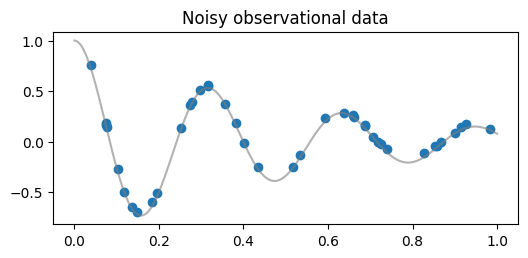

In [13]:
#first, create some noisy observational data

torch.manual_seed(123)
d,w0 = 2,20
print(f"True value of mu:{2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d,w0,t_obs)+ 0.04*torch.rand_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d,w0,t_test)

plt.figure(figsize = (6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0],u_exact[:,0],label="exact solution", color="tab:grey", alpha=.6)
plt.show()


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Nirajan\AppData\Local\Temp\ipykernel_13636\2409722116.py:63: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$")


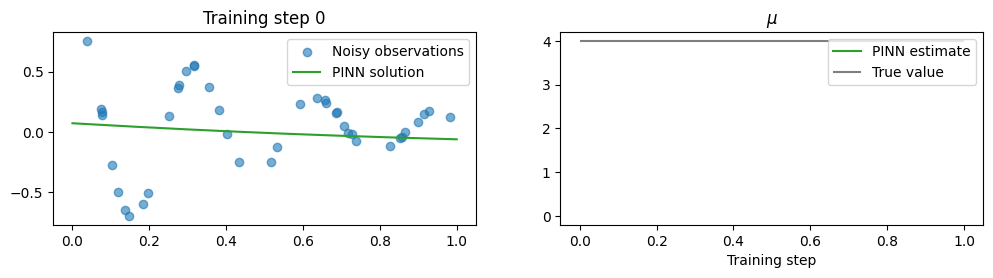

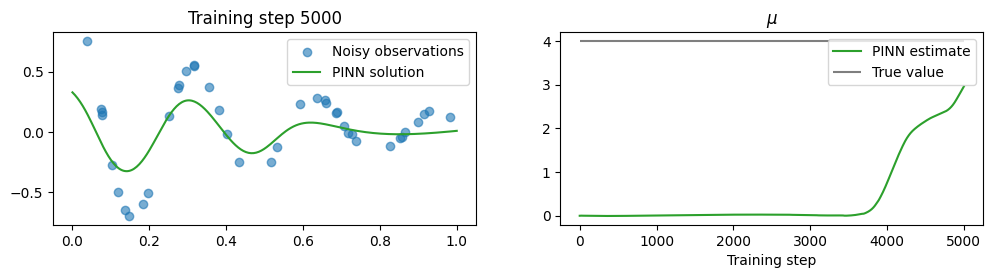

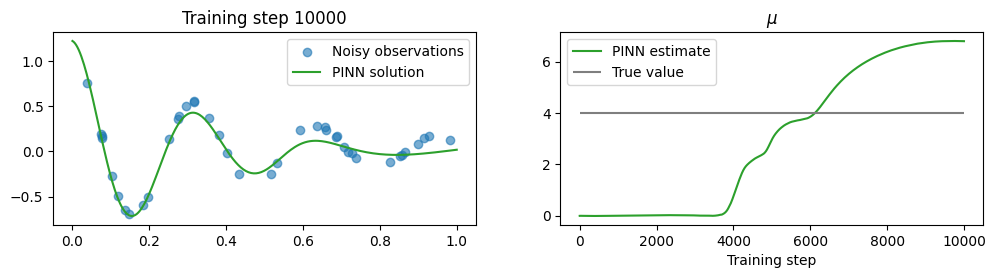

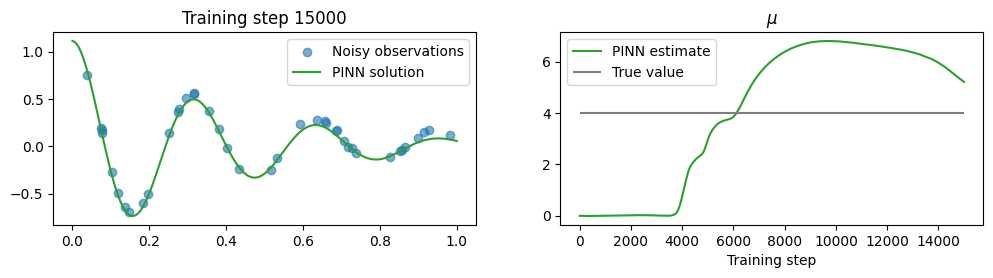

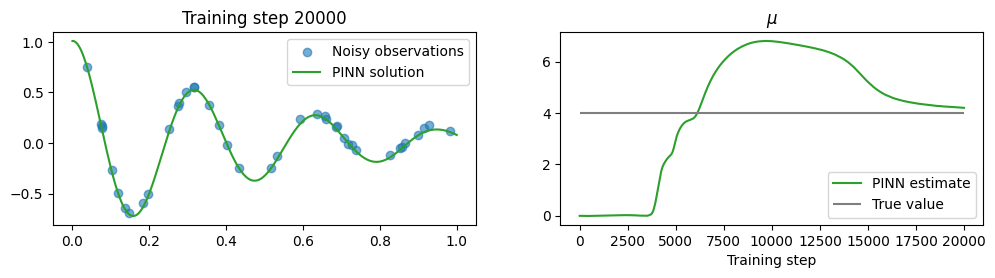

In [22]:
torch.manual_seed(123)

#define a neural network to train
pinn = FCN(1,1,32,3)

#define training pints over the entire domain for the physics loss
t_physics= torch.linspace(0,1,30).view(-1,1).requires_grad_(True) #(30,1)


#train the PINN
d,w0 = 2,20

_,k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d,w0,t_test)


#treat mu as a learnable parameter, add it to optimizer
mu = nn.Parameter(torch.tensor(0.,requires_grad=True))

optimizer = torch.optim.Adam(list(pinn.parameters())+[mu], lr = 1e-3)

mus = []

for i in range(20001):
    optimizer.zero_grad()

    #hyperparameters
    lambda1 = 1e4


    #compute physics loss
    u =pinn(t_physics) #(30,1)
    dudt = torch.autograd.grad(u,t_physics,torch.ones_like(u), create_graph =True)[0] #(30,1)
    d2udt2 = torch.autograd.grad(dudt,t_physics,torch.ones_like(u), create_graph =True)[0] #(30,1)
    loss1 = torch.mean((d2udt2+mu*dudt+k*u)**2)

   #compute data loss

    u =pinn(t_obs)
    loss2 = torch.mean((u-u_obs)**2)

    #backpropagate joint loss, take optimizer step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimizer.step()

    #record mu value
    mus.append(mu.item())

    #plot the result as training progresses
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(12,2.5))

        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2*d, 0, len(mus), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()
        
        plt.show()



